In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crude-oil-price/crude-oil-price.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')

In [3]:
class CFG:
    IMDIM1 = 15
    IMDIM2 = 10

In [4]:
plt.rcParams.update({'figure.figsize': (CFG.IMDIM1, CFG.IMDIM2)})

In [5]:
df = pd.read_csv('/kaggle/input/crude-oil-price/crude-oil-price.csv')
df.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646396,1.36
2,1983-05-02T00:00:00,30.25,-1.240614,-0.38
3,1983-06-01T00:00:00,31.38,3.735537,1.13
4,1983-07-01T00:00:00,32.00,1.975781,0.62


In [6]:
df.fillna(0, inplace = True)

<AxesSubplot:xlabel='date'>

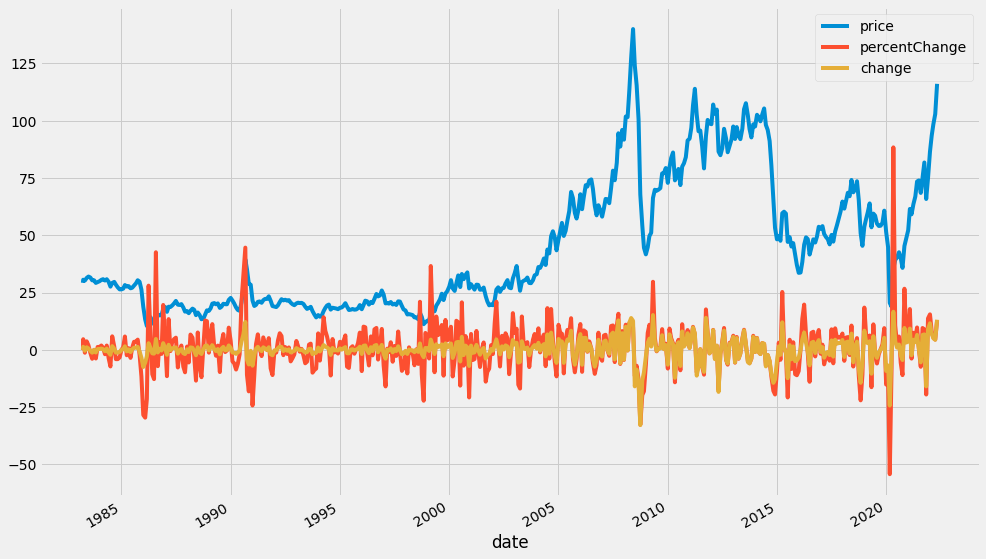

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

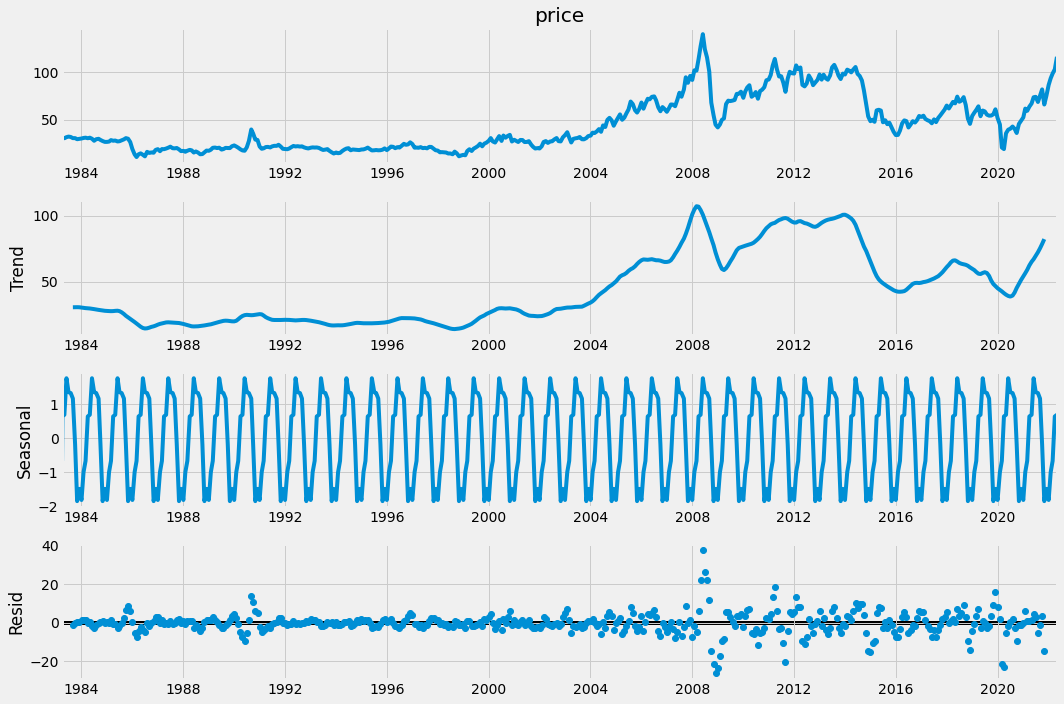

In [8]:
decomposition = seasonal_decompose(df['price'], period = 12)
figure = decomposition.plot()
plt.show()